# Generative Adversarial Networks (GAN)

## Objectives
- To learn about GAN
- To train a model using GAN
- To train a model using cGAN
- To make comparision

## Theory
**GAN:** using deep learning to train generative models. It has the archetcture of:
- **Generator:** responsible for generating new plausabile examples that ideally indistingishable from real eaxamples in the dataset.
- **Discriminator:** is responsible for classifting a given image as either real or fake.

**Adversial:** zero-sum : improvemnets in the discrimiter come at the cost of reducing the capability of the generator.

Image synthesis (GAN is effective).

In the case that we make use of the labels:
- Improve the GAN.
- Targeted Generation.

**The limitation of GAN:** (There is a relationship between points in the latent space to the generated images, but this relationship is complex and hard to map) it might generate random image from the domain.

If we trainied it in such way that the descriminator and the generators are conditioned on the class label as an alternative. An example is genertaed number 9 from the digits dataset. It's called **cGAN**

**Deep convolutional GAN (DCGAN):** stable traiing of GAN models. 
The conditional traininng of the DCGAN-based models may be reffered to as cDCGAN). 

Best practice to incorpiirate the class labels into the discriminator is using the embeding layer -> FC -> Linear activation.

**IDS: Intrusion Detection Systems:** the research about finding attacks and removing their effects. (Classification task). It's an unsloved problem since the attcjers are evovling. (Research gap)

Neccessary imports

In [1]:
import keras
from keras import layers
from keras import ops
import tensorflow as tf
import numpy as np
import imageio
from matplotlib import pyplot as plt
from keras import Sequential

2024-05-01 19:37:51.405096: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 19:37:51.405209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 19:37:51.571463: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


- Loading the MNIST dataset

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


- Sample of size 100 the dataset before preprocess:

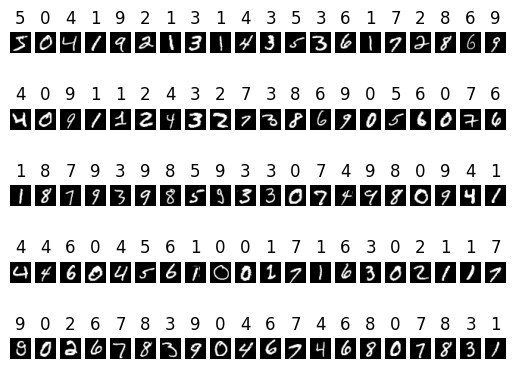

In [3]:
for i in range(100):
    plt.subplot(5, 20, 1 + i)
    plt.axis('off')
    plt.imshow(x_train[i], cmap='gray')
    plt.title(y_train[i])
plt.show()

### Dataset Preparing:

- Images preprocessing and Labels preparing

In [4]:
def prepare_dataset(X, y):
    """
    Takes labels and images and prepare them
    Args:
        X (np.array): the images of the dataset
        y (np.array): the labels of the dataset
    Returns:
        dataset(tf.data.Dataset): teh prepared datset
    """
    X = np.expand_dims(X, axis=-1)
    X = X.astype('float32')
    X = (X - 127.5) / 127.5
    return X, y

In [5]:
x_train, y_train = prepare_dataset(x_train, y_train)
x_test, y_test = prepare_dataset(x_test, y_test)

- Sample after preprocessing:

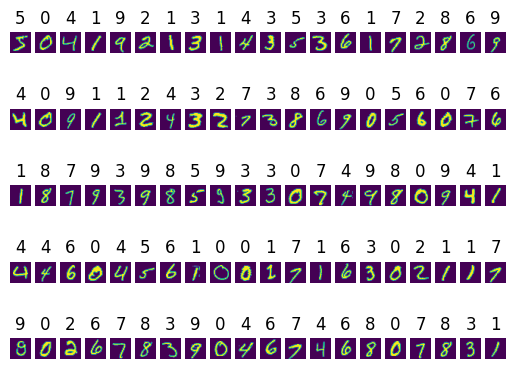

In [6]:
for i in range(100):
    plt.subplot(5, 20, 1 + i)
    plt.axis('off')
    plt.imshow(x_train[i])
    plt.title(y_train[i])
plt.show()

In [7]:
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


## Data Modeling

### Uncondtional GAN

#### Model Architicture

- Discrimtor

In [8]:
def discriminator_arch(input_shape=(28, 28, 1)):
    """
    This is the discriminator part of the GAN
    Args:
        input_shape=(28, 28, 1)
    Returns:
        discriminator(keras.Sequential): discriminator part
    """
    discriminator = Sequential([
        # Downsampling
        layers.Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=input_shape),
        layers.LeakyReLU(),
        layers.Conv2D(128, (3,3), strides=(2,2), padding='same'),
        layers.LeakyReLU(),
        
        # Classifier
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ], 
    name="discriminator")
    
    discriminator.compile(optimizer= 'adam',loss='categorical_crossentropy', metrics=['accuracy'])
    return discriminator

- Generator

In [9]:
def generator_arch(latent_dim):
    """
    Generter part of the GAN arch.
    Args:
        latent_dim(int)
    Returns:
        generator (keras.Sequential):
    """
    n_nodes = 128 * 7 * 7
    generator = Sequential([
        # create the base for the image
        layers.Dense(n_nodes, input_dim=latent_dim),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 128)), 
     
        # Upsample to 14x14
        layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'),
        layers.LeakyReLU(),
 
        # upsample to 28x28
        layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'),
        layers.LeakyReLU(),
        layers.Conv2D(1, (7,7), activation='tanh', padding='same')    
    ],
    name="generator")

    return generator

- Uncoditional GAN:

In [10]:
def gan_arch(generator, discriminator):
    """
    To create the uGAN model from two base sequential models
    Args:
        generator (keras.Sequential):
        discriminator (keras.Sequential):
    Returns:
        ugan (keras.Sequential): the uncodntional GAN model
    """
    discriminator.trainable = False
    ugan = Sequential([
        generator,
        discriminator
    ],
    name="uGAN")
    ugan.compile(optimizer= 'adam',loss='categorical_crossentropy', metrics=['accuracy'])
    return ugan

#### Training

In [11]:
def generate_real_samples(dataset, n_samples):
    """
    Args:
        dataset
        n_samples
    Returns:
        
    """
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y

In [12]:
def generate_latent_points(latent_dim, n_samples):
    """
    Args:
    Returns:
    """
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [13]:
def generate_fake_samples(generator, latent_dim, n_samples):
    """
    Args:
    Returns:
    """
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

In [14]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=128):
    """
    Args:
    Returns:
    
    """
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        
        d_loss1_ep = 0.0
        d_loss2_ep = 0.0
        g_loss_ep = 0.0
        
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
        
            d_loss1_ep += d_loss1
            d_loss2_ep += d_loss2
            g_loss_ep += g_loss[1]
            
        d_loss1_avg = d_loss1_ep / bat_per_epo
        d_loss2_avg = d_loss2_ep / bat_per_epo
        g_loss_avg = g_loss_ep / bat_per_epo
        
        print("Epoch %d: d_loss1=%.3f, d_loss2=%.3f, g_loss=%.3f" % (i+1, d_loss1_avg, d_loss2_avg, g_loss_avg))
    g_model.save('generator.h5')

### Conditional GAN

## Refrences 

- https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/